# Distance errors in APOGEE DR17

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
from apogee_tools import import_apogee, apogee_region
import paths
from utils import quad_add, get_bin_centers, get_color_list
import _globals

In [2]:
apogee_data = import_apogee()
apogee_data['GAIAEDR3_R_PHOTOGEO_ERR'] = quad_add(
    apogee_data['GAIAEDR3_R_HI_PHOTOGEO'] - apogee_data['GAIAEDR3_R_MED_PHOTOGEO'], 
    apogee_data['GAIAEDR3_R_MED_PHOTOGEO'] - apogee_data['GAIAEDR3_R_LO_PHOTOGEO'])

In [3]:
bin_dist_err = apogee_data.groupby([pd.cut(apogee_data['GALR'], _globals.GALR_BINS), 
                                    pd.cut(apogee_data['GALZ'], _globals.ABSZ_BINS)], 
                                    observed=False)['GAIAEDR3_R_PHOTOGEO_ERR'].median()
bin_dist_err

GALR      GALZ      
(3, 5]    (0.0, 0.5]    1497.932337
          (0.5, 1.0]     994.239272
          (1.0, 2.0]     809.327637
(5, 7]    (0.0, 0.5]     276.406859
          (0.5, 1.0]     235.301909
          (1.0, 2.0]     168.550187
(7, 9]    (0.0, 0.5]      28.737968
          (0.5, 1.0]      22.598741
          (1.0, 2.0]      62.036065
(9, 11]   (0.0, 0.5]     158.379738
          (0.5, 1.0]      96.723743
          (1.0, 2.0]     151.567415
(11, 13]  (0.0, 0.5]     499.535682
          (0.5, 1.0]     448.447229
          (1.0, 2.0]     467.279045
(13, 15]  (0.0, 0.5]    1437.487783
          (0.5, 1.0]    1188.120639
          (1.0, 2.0]    1199.369591
Name: GAIAEDR3_R_PHOTOGEO_ERR, dtype: float64

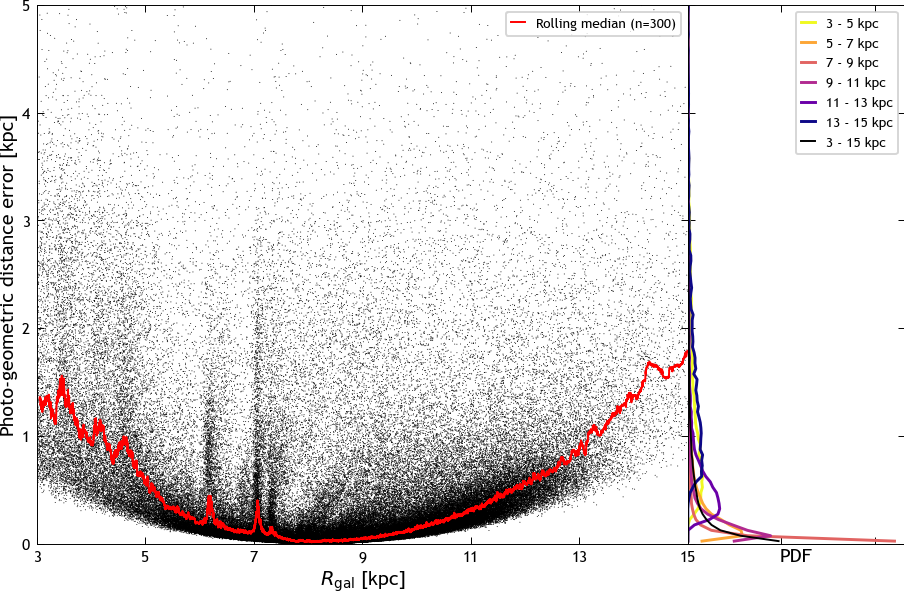

In [11]:
fig = plt.figure(figsize=(8, 5), dpi=140)
plt.style.use(paths.styles / 'poster.mplstyle')
gs = fig.add_gridspec(1, 2, width_ratios=(3, 1), wspace=0., hspace=0.)
# Main axis: scatter plot of R_gal vs distance error
ax0 = fig.add_subplot(gs[0,0])
apogee_subset = apogee_region(apogee_data, galr_lim=(3, 15), absz_lim=(0, 2))
ax0.scatter(apogee_subset['GALR'], apogee_subset['GAIAEDR3_R_PHOTOGEO_ERR']/1000, 
           s=1, marker='.', c='k', edgecolor='none')
# Rolling median
apogee_sorted = apogee_subset.sort_values('GALR')
n = 300
rolling_dist_err_med = apogee_sorted['GAIAEDR3_R_PHOTOGEO_ERR'].rolling(n).median()
ax0.plot(apogee_sorted['GALR'], rolling_dist_err_med/1000, 'r-', 
         label='Rolling median (n=%s)' % n)
ax0.set_xlim((3, 15))
ax0.set_xticks(_globals.GALR_BINS)
ax0.set_ylim((0, 5))
# ax0.set_yscale('log')
ax0.set_xlabel(r'$R_{\rm gal}$ [kpc]')
ax0.set_ylabel('Photo-geometric distance error [kpc]')
ax0.legend(loc='upper right', handlelength=1.)
# Marginal axis: distribution of distance errors by R_gal
ax1 = fig.add_subplot(gs[0,1], sharey=ax0)
# err_bins = np.logspace(-2, 1, 100)
err_bins = np.arange(0, 5.05, 0.05)
# Plot histograms for each region
colors = get_color_list(plt.get_cmap('plasma_r'), _globals.GALR_BINS)
for i in range(len(_globals.GALR_BINS)-1):
    galr_lim = (_globals.GALR_BINS[i], _globals.GALR_BINS[i+1])
    apogee_subset = apogee_region(apogee_data, galr_lim, (0, 2))
    subset_hist = np.histogram(apogee_subset['GAIAEDR3_R_PHOTOGEO_ERR']/1000, 
                               bins=err_bins, density=True)[0]
    ax1.plot(subset_hist, get_bin_centers(err_bins), marker='none',
              linestyle='-', color=colors[i], label='%s - %s kpc' % galr_lim,
             linewidth=1.5)
# Histogram of all stars
apogee_subset = apogee_region(apogee_data, galr_lim=(3, 15), absz_lim=(0, 2))
total_hist = np.histogram(apogee_subset['GAIAEDR3_R_PHOTOGEO_ERR']/1000, 
                          bins=err_bins, density=True)[0]
ax1.plot(total_hist, get_bin_centers(err_bins), 'k-', label='3 - 15 kpc')
ax1.tick_params(axis='y', labelleft=False)
ax1.tick_params(axis='x', labelbottom=False)
ax1.set_xlim((0, None))
ax1.set_xlabel('PDF')
ax1.legend(loc='upper right', handlelength=1.)
plt.show()

## Abundance uncertainty dispersion

In [14]:
for col in ['FE_H_ERR', 'O_FE_ERR', 'LOG_LATENT_AGE_ERR']:
    subset = apogee_data.dropna(subset=col)
    print(col)
    print('\tMedian uncertainty: %s' % subset[col].median())
    print('\tDispersion (95-5): %s' % (np.quantile(subset[col], 0.95) - np.quantile(subset[col], 0.05)))

FE_H_ERR
	Median uncertainty: 0.008902398
	Dispersion (95-5): 0.006011581779999999
O_FE_ERR
	Median uncertainty: 0.01851876
	Dispersion (95-5): 0.030857730200000003
LOG_LATENT_AGE_ERR
	Median uncertainty: 0.100301975
	Dispersion (95-5): 0.16447577309999997
